In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
np.random.seed(25)
import os
import warnings 
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test_bqCt9Pv.csv')

In [3]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


### Handling Null Values

In [4]:
train.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

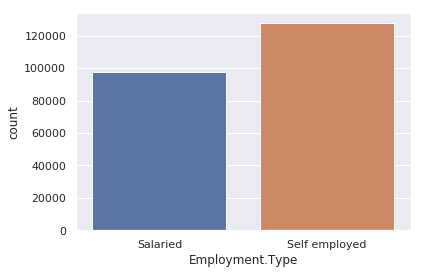

In [5]:
sns.countplot(train['Employment.Type'])

In [6]:
train['Employment.Type'].fillna('Other', inplace=True)
test['Employment.Type'].fillna('Other', inplace=True)

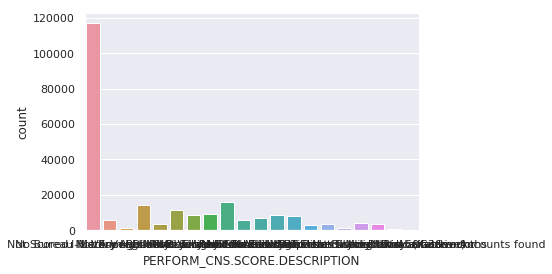

In [7]:
sns.countplot(train['PERFORM_CNS.SCORE.DESCRIPTION'])

In [8]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
train["PERFORM_CNS.SCORE.DESCRIPTION"] = lb_make.fit_transform(train["PERFORM_CNS.SCORE.DESCRIPTION"])
train["Employment.Type"] = lb_make.fit_transform(train["Employment.Type"])

test["PERFORM_CNS.SCORE.DESCRIPTION"] = lb_make.fit_transform(test["PERFORM_CNS.SCORE.DESCRIPTION"])
test["Employment.Type"] = lb_make.fit_transform(test["Employment.Type"])

In [9]:
# Date features
train["Date.of.Birth"] = train['Date.of.Birth'].astype('datetime64[ns]')
test["Date.of.Birth"] = test['Date.of.Birth'].astype('datetime64[ns]')

train["DisbursalDate"] = train['DisbursalDate'].astype('datetime64[ns]')
test["DisbursalDate"] = test['DisbursalDate'].astype('datetime64[ns]')

## generate features from date column

train["birth_DayOfMonth"] = train["Date.of.Birth"].apply(lambda x: x.day)
test["birth_DayOfMonth"] = test["Date.of.Birth"].apply(lambda x: x.day)
train["birth_Month"] = train["Date.of.Birth"].apply(lambda x: x.month)
test["birth_Month"] = test["Date.of.Birth"].apply(lambda x: x.month)
train["birth_Year"] = train["Date.of.Birth"].apply(lambda x: x.year)
test["birth_Year"] = test["Date.of.Birth"].apply(lambda x: x.year)
train["birth_WeekDay"] = train["Date.of.Birth"].apply(lambda x: x.weekday())
test["birth_WeekDay"] = test["Date.of.Birth"].apply(lambda x: x.weekday())
train["birth_WeekNo"] = train["Date.of.Birth"].apply(lambda x: x.isocalendar()[1])
test["birth_WeekNo"] = test["Date.of.Birth"].apply(lambda x: x.isocalendar()[1])
train["birth_DayOfYear"] = train["Date.of.Birth"].apply(lambda x: x.timetuple().tm_yday)
test["birth_DayOfYear"] = test["Date.of.Birth"].apply(lambda x: x.timetuple().tm_yday)
# train["birth_DayCount"] = train["Date.of.Birth"].apply(lambda x: x.toordinal())
# test["birth_DayCount"] = test["Date.of.Birth"].apply(lambda x: x.toordinal())

train["disp_DayOfMonth"] = train["DisbursalDate"].apply(lambda x: x.day)
test["disp_DayOfMonth"] = test["DisbursalDate"].apply(lambda x: x.day)
train["disp_Month"] = train["DisbursalDate"].apply(lambda x: x.month)
test["disp_Month"] = test["DisbursalDate"].apply(lambda x: x.month)
train["disp_Year"] = train["DisbursalDate"].apply(lambda x: x.year)
test["disp_Year"] = test["DisbursalDate"].apply(lambda x: x.year)
train["disp_WeekDay"] = train["DisbursalDate"].apply(lambda x: x.weekday())
test["disp_WeekDay"] = test["DisbursalDate"].apply(lambda x: x.weekday())
train["disp_WeekNo"] = train["DisbursalDate"].apply(lambda x: x.isocalendar()[1])
test["disp_WeekNo"] = test["DisbursalDate"].apply(lambda x: x.isocalendar()[1])
train["disp_DayOfYear"] = train["DisbursalDate"].apply(lambda x: x.timetuple().tm_yday)
test["disp_DayOfYear"] = test["DisbursalDate"].apply(lambda x: x.timetuple().tm_yday)
# train["disp_DayCount"] = train["DisbursalDate"].apply(lambda x: x.toordinal())
# test["disp_DayCount"] = test["DisbursalDate"].apply(lambda x: x.toordinal())

In [10]:
sum(((train['DisbursalDate'] - train['Date.of.Birth']).dt.days / 365) < 0)

19866

In [11]:
train['Age_during_applying'] = (train['DisbursalDate'] - train['Date.of.Birth']).dt.days / 365
test['Age_during_applying'] = (train['DisbursalDate'] - test['Date.of.Birth']).dt.days / 365
train['Age_during_applying'] = np.where(train['Age_during_applying'] < 0, 100+train['Age_during_applying'], train['Age_during_applying'])
test['Age_during_applying'] = np.where(test['Age_during_applying'] < 0, 100+test['Age_during_applying'], test['Age_during_applying'])

In [12]:
tenure_list = []
time_list = []
for i in range(len(train)):
    avg_loan_tenure = train['AVERAGE.ACCT.AGE'][i]
    avg_loan_tenure = avg_loan_tenure.replace('yrs','')
    avg_loan_tenure = avg_loan_tenure.replace('mon','')
    x = avg_loan_tenure.split(' ')
    tenure_list.append(int(x[0]) * 12 + int(x[1]))
    
    last_loan = train['CREDIT.HISTORY.LENGTH'][i]
    last_loan = last_loan.replace('yrs','')
    last_loan = last_loan.replace('mon','')
    x = last_loan.split(' ')
    time_list.append(int(x[0]) * 12 + int(x[1]))

train['AVERAGE.ACCT.AGE'] = tenure_list
train['CREDIT.HISTORY.LENGTH'] = time_list

tenure_list = []
time_list = []
for i in range(len(test)):
    avg_loan_tenure = test['AVERAGE.ACCT.AGE'][i]
    avg_loan_tenure = avg_loan_tenure.replace('yrs','')
    avg_loan_tenure = avg_loan_tenure.replace('mon','')
    x = avg_loan_tenure.split(' ')
    tenure_list.append(int(x[0]) * 12 + int(x[1]))
    
    last_loan = test['CREDIT.HISTORY.LENGTH'][i]
    last_loan = last_loan.replace('yrs','')
    last_loan = last_loan.replace('mon','')
    x = last_loan.split(' ')
    time_list.append(int(x[0]) * 12 + int(x[1]))

test['AVERAGE.ACCT.AGE'] = tenure_list
test['CREDIT.HISTORY.LENGTH'] = time_list

In [13]:
train["num_of_completed_pri_loans"] = train["PRI.NO.OF.ACCTS"] - train['PRI.ACTIVE.ACCTS']
test["num_of_completed_pri_loans"] = test["PRI.NO.OF.ACCTS"] - test['PRI.ACTIVE.ACCTS'] 

train["num_of_completed_sec_loans"] = train["SEC.NO.OF.ACCTS"] - train['SEC.ACTIVE.ACCTS']
test["num_of_completed_sec_loans"] = test["SEC.NO.OF.ACCTS"] - test['SEC.ACTIVE.ACCTS']

train["pri_diff_loan_amount"] = train["PRI.SANCTIONED.AMOUNT"] - train['PRI.DISBURSED.AMOUNT']
test["pri_diff_loan_amount"] = test["PRI.SANCTIONED.AMOUNT"] - test['PRI.DISBURSED.AMOUNT']

train["sec_diff_loan_amount"] = train["SEC.SANCTIONED.AMOUNT"] - train['SEC.DISBURSED.AMOUNT']
test["sec_diff_loan_amount"] = test["SEC.SANCTIONED.AMOUNT"] - test['SEC.DISBURSED.AMOUNT']

train['asset_to_loan_pct'] =  train['asset_cost'] / train['disbursed_amount']
test['asset_to_loan_pct'] =  test['asset_cost'] / test['disbursed_amount']

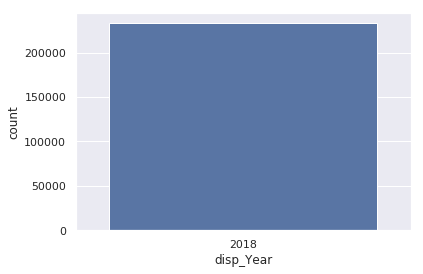

In [14]:
sns.countplot((train['disp_Year']))

In [15]:
# feature transformation
train['disbursed_amount'] = np.log1p(train['disbursed_amount'])
train['asset_cost'] = np.log1p(train['asset_cost'])

test['disbursed_amount'] = np.log1p(test['disbursed_amount'])
test['asset_cost'] = np.log1p(test['asset_cost'])

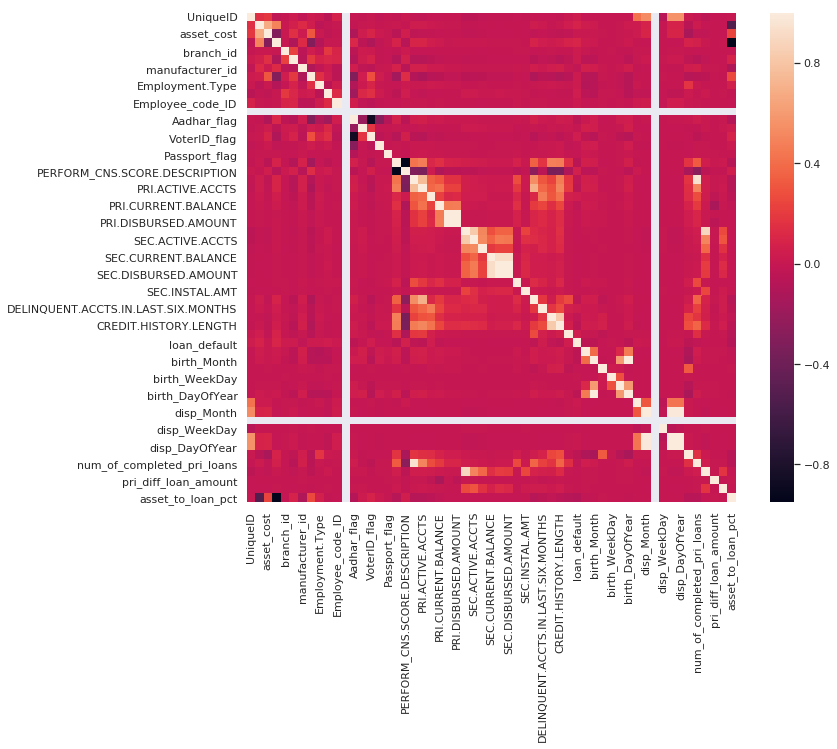

In [16]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

In [17]:
target = train['loan_default']

In [18]:
train.shape

(233154, 59)

In [19]:
## features to be included in the model
feature_names = [x for x in train.columns if x not in ['UniqueID','loan_default',
                                                      'Date.of.Birth', 'DisbursalDate','MobileNo_Avl_Flag']]

In [20]:
x_train, x_test, y_train, y_test = train_test_split(train[feature_names].values, target,
                                                    test_size=0.2,
                                                    random_state=2019)
model = lgb.LGBMClassifier(verbose=0)
model.fit(x_train, y_train)
print(model.feature_importances_)

[120  93 139 138 146  62 303  59  81 110  14  11  14   1   0 157  15  39
  32  64  54  62  38   4   0   1  13   1   4  92   4  28  43  63  90  62
  51   3  34  21  27  75  99  26   0  21  12  86 166  56   1  60   0 105]


In [21]:
fea_imp_ = pd.DataFrame({'cols':train[feature_names].columns, 'fea_imp':model.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False).reset_index()

,index,cols,fea_imp
0,6,Current_pincode_ID,303
1,48,Age_during_applying,166
2,15,PERFORM_CNS.SCORE,157
3,4,supplier_id,146
4,2,ltv,139
5,3,branch_id,138
6,0,disbursed_amount,120
7,9,Employee_code_ID,110
8,53,asset_to_loan_pct,105
9,42,disp_DayOfMonth,99


In [22]:
reduced_features = list(fea_imp_[fea_imp_['fea_imp']>20]['cols'])

In [23]:
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.metrics import roc_curve
x_train, x_test, y_train, y_test = train_test_split(train[reduced_features].values, target,
                                                    test_size=0.2,
                                                    random_state=2019)
model = xgb.XGBClassifier(n_estimators=1000,n_jobs = -1,max_depth=8,learning_rate=0.01, colsample_bytree=0.8, subsample=1.0
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

# AUC ROC CURVE
predictions = model.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_pred, average='weighted')

fpr, tpr, threshold = roc_curve(y_test, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

SyntaxError: invalid syntax (<ipython-input-23-5c4a057dd294>, line 7)

In [24]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score, make_scorer,roc_auc_score
# model = xgb.XGBClassifier(n_estimators=900,n_jobs = -1,max_depth=8,learning_rate=0.01, colsample_bytree=0.8, subsample=1.0)
# print(cross_val_score(model, train[feature_names], target, cv=3, scoring=make_scorer(roc_auc_score)))

In [25]:
model = xgb.XGBClassifier(n_estimators=1000,n_jobs = -1,max_depth=8,learning_rate=0.01, colsample_bytree=0.8, subsample=1.0)
model.fit(train[reduced_features],target)
pred = model.predict_proba(test[reduced_features])

In [26]:
## make submission
sub = pd.DataFrame()
sub['UniqueID'] = test['UniqueID']
sub['loan_default'] = [i[1] for i in pred]
sub.to_csv('result.csv', index=False)